In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Calculating the BCS ground state on quantum hardware
___

This notebook executes the example outlined in Sec. 7.1.

First, we need some preliminary definitions -- the number of k-points `Nk` and the dispersion relation
$\epsilon(k)$ for the material. The number of $k$ points should be checked for convergence in a
real calculation.

In [2]:
# Preliminary definitions and functions
Nk = 50

# Dispersion relation
def eps(k):
    return -2*cos(k)


Classical optimization example
---

For reference, we outline how the calculation is done on classical hardware. We optimize the total
energy (Eqs. 17 & 18). The angle $\theta_k$ parametrizes the direction of the pseudospin at momentum k;
the $z$-component
corresponds to the density, whereas the $x$ component corresponds to the anomalous (superconducting)
density.

Since one of the parameters, $\Delta$ depends on all the $k$ points, this is a non-linear optimization procedure.
We use the default optimizer in `scipy` to minimize the total energy; as an initial guess for the $\theta$ parameters, we use the zero-temperature non-interacting result with a small random variation.

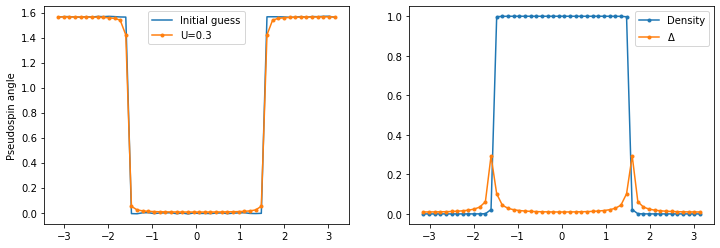

In [3]:
def classical_optimization(U,klist,eklist,theta):
    """
    Optimize the pseudospin angle in the x-z plane without any
    mention of a quantum circuit

    Argument: the attractive interaction strength (0.3 is reasonable and works)
    """
    from scipy.optimize import minimize

    # Here we use the total energy as the cost function. 
    def costfunc(theta):

        # Calculate new delta
        delta = U * sum(sin(2.*theta))/Nk

        energy = sum(eklist * cos(2.*theta) - delta * sin(2.*theta))

        return energy

    res = minimize(costfunc, theta)

    return res

# Set up arrays and look-up tables
klist = linspace(-pi,pi,Nk)
eklist = eps(klist)
# inital guess for thetas
theta = zeros(Nk)
theta[where(abs(klist)>pi/2)] = pi/2
theta -= random.rand(Nk) * 0.01

res = classical_optimization(0.3,klist,eklist,theta)

# After obtaining the optimized result, plot the resulting angles
fig, (ax1,ax2) = subplots(1,2,figsize=(12,4))
ax1.plot(klist,theta, label="Initial guess")
ax1.plot(klist,res.x,'.-',label="U=0.3")
ax1.set_ylabel("Pseudospin angle")
ax1.legend()

# Plot the resulting density
ax2.plot(klist,0.5*(cos(2*res.x)+1),'.-',label="Density")
ax2.plot(klist,sin(2*res.x),'.-',label="$\Delta$")
ax2.legend()


#print("Final gap=",U * sum(sin(2*res.x))/Nk)
#print("Energy=",costfunc(res.x))

The plots above show the initial guess and final result for $\theta_k$, and the corresponding
density and order parameter.
____
Quantum optimization example: matrix representation
----
To continue our illustration, we recast the exact optimization procedure above in a gated quantum computing model. Each $k$ point gets an individual qubit, which is rotated by its angle $\theta_k$, and then measured. The QC is modeled through a simple matrix-vector multiplication
in the 2-dimensional Hilbert space.
The rest of the optimization procedure remains the same.

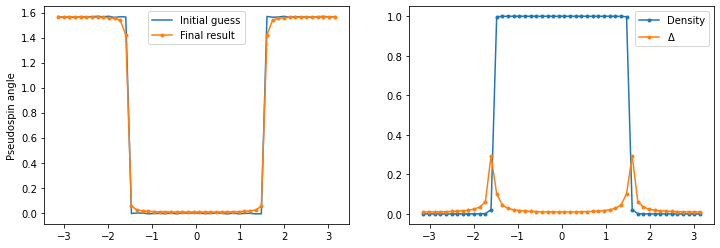

In [4]:
Nk=50
def quantum_optimization(U,klist,eklist,theta):
    """
    Optimize the pseudospin angle in the x-z plane by using a single rotation
    gate (Ry)

    Argument: the attractive interaction strength (0.3 is reasonable and works)
    """
    from scipy.optimize import minimize
    
    # Here we use the total energy as the cost function.     
    def costfunc(theta):

        c2th = zeros(Nk)
        s2th = zeros(Nk)

        # Build and run each k point individually
        for ik in range(Nk):

            # Quantum circuit implemented using matrix operations
            vec0 = np.array([1,0])
            vec1 = ry(2*theta[ik]) @ vec0

            # Measure z and x expectation values
            zz = vec1 @ sz @ vec1
            xx = vec1 @ sx @ vec1

            c2th[ik] = zz
            s2th[ik] = xx

        # Calculate new delta
        delta = U * sum(s2th)/Nk
        
        # And new energy
        energy = sum(eklist * c2th - delta * s2th)

        return energy
    
    res = minimize(costfunc, theta)
    return res


# Utility definitions
def ry(theta):
    cth = cos(theta/2)
    sth = sin(theta/2)
    return np.array([[cth,-sth],[sth,cth]])

sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1.j],[1.j,0]])
sz = np.array([[1,0],[0,-1]])

# Set up arrays and look-up tables
klist = linspace(-pi,pi,Nk)
eklist = eps(klist)

# Theta guess
theta = zeros(Nk)
theta[where(abs(klist)>pi/2)] = pi/2
theta -= random.rand(Nk) * 0.01


res_quantum = quantum_optimization(0.3,klist,eklist,theta)

# After obtaining the optimized result, plot the resulting angles
fig, (ax,ax2) = subplots(1,2,figsize=(12,4))
ax.plot(klist,theta, label="Initial guess")
ax.plot(klist,res_quantum.x,'.-',label="Final result")
ax.set_ylabel("Pseudospin angle")
ax.legend()

# Plot the resulting density and superconducting order parameter
ax2.plot(klist,0.5*(cos(2*res_quantum.x)+1),'.-',label="Density")
ax2.plot(klist,sin(2*res_quantum.x),'.-',label="$\Delta$")
ax2.legend()
    
#print("Final gap=",U * sum(sin(2*res.x))/Nk)
#print("Energy=",costfunc(res.x))

As expected the results are identical.
____
Quantum optimization example: Qiskit simulators
----
We repeat the example above, but in this case we use Qiskit to create the quantum circuit, and the `statevector_simulator` to run the calculation.  With the `statevector_simulator` the $x$ and $z$ components can be directly obtained -- actual QC hardware or a
non-statevector simulator would require separate measurements for these. The rest of the optimization procedure remains the same,
although several bits of code are added to make Qiskit work.

<span style="color:red">**This code takes some time to run.**</span>

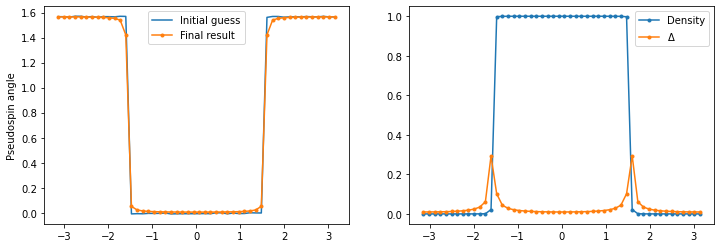

In [5]:
def qiskit_demonstration(U,klist,eklist,theta):
    """ 
    Demonstration in Qiskit.
    """
    
    from qiskit import Aer, execute, QuantumCircuit
    backend = Aer.get_backend('statevector_simulator')
    from scipy.optimize import minimize

    # Given an angle, produce a quantum circuit that applies the appropriate
    # rotation and measures the z/x projections. In a real machine, the statevector
    # expectation values should be replaced with direct measurements (for z) or
    # measurements after rotation into the x basis.
    
    def measure_kpoint(theta):
        qc = QuantumCircuit(1)
        qc.ry(2*theta,0)

        result = execute(qc,backend).result()
        vec = result.get_statevector()

        zz = real(conjugate(vec) @ sz @ vec)
        xx = real(conjugate(vec) @ sx @ vec)

        return zz,xx
    
    # This is the cost function to use for optimization within Qiskit
    def costfunc(theta):
        c2th = zeros(Nk)
        s2th = zeros(Nk)
        #loop over k-points
        for ik in range(Nk):
            #measure expectation values of Pauli-X and -Z operators
            zz, xx = measure_kpoint(theta[ik])
            c2th[ik] = zz
            s2th[ik] = xx
        # Calculate new delta
        delta = U * sum(s2th)/Nk
        energy = sum(eklist * c2th - delta * s2th)
        return energy

    res = minimize(costfunc, theta)
    return res

Nk = 50
# Set up arrays and look-up tables
klist = linspace(-pi,pi,Nk)
eklist = eps(klist)

# Theta guess
theta = zeros(Nk)
theta[where(abs(klist)>pi/2)] = pi/2
theta -= random.rand(Nk) * 0.01

res_qiskit = qiskit_demonstration(0.3,klist,eklist,theta)

# After obtaining the optimized result, plot the resulting angles
fig, (ax,ax2) = subplots(1,2,figsize=(12,4))
ax.plot(klist,theta, label="Initial guess")
ax.plot(klist,res_qiskit.x,'.-',label="Final result")
ax.set_ylabel("Pseudospin angle")
ax.legend()

# Plot the resulting density and superconducting order parameter
ax2.plot(klist,0.5*(cos(2*res_qiskit.x)+1),'.-',label="Density")
ax2.plot(klist,sin(2*res_qiskit.x),'.-',label="$\Delta$")
ax2.legend()
